In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# CatBoost
from catboost import CatBoostClassifier, Pool

# SHAP for feature importance
import shap

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [15]:
# Load the dataset
df = pd.read_csv('ev_charging_patterns.csv')

# Display the first few rows
df.head()
# Check data types and missing values
df.info()
df.isnull().sum()
# Statistical summary
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1320 non-null   object 
 1   Vehicle Model                             1320 non-null   object 
 2   Battery Capacity (kWh)                    1320 non-null   float64
 3   Charging Station ID                       1320 non-null   object 
 4   Charging Station Location                 1320 non-null   object 
 5   Charging Start Time                       1320 non-null   object 
 6   Charging End Time                         1320 non-null   object 
 7   Energy Consumed (kWh)                     1254 non-null   float64
 8   Charging Duration (hours)                 1320 non-null   float64
 9   Charging Rate (kW)                        1254 non-null   float64
 10  Charging Cost (USD)                 

,Battery Capacity (kWh),Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years)
count,1320.000000,1254.000000,1320.000000,1254.000000,1320.000000,1320.000000,1320.000000,1254.000000,1320.000000,1320.000000
mean,74.534692,42.642894,2.269377,25.963003,22.551352,49.130012,75.141590,153.596788,15.263591,3.612843
std,20.626914,22.411705,1.061037,14.011326,10.751494,24.074134,17.080580,86.004987,14.831216,2.309824
min,1.532807,0.045772,0.095314,1.472549,0.234317,2.325959,7.604224,0.862361,-10.724770,0.000000
25%,62.000000,23.881193,1.397623,13.856583,13.368141,27.786903,62.053266,79.445335,2.800664,2.000000
50%,75.000000,42.691405,2.258136,25.603799,22.076360,48.241771,75.682496,152.259867,14.630846,4.000000
75%,85.000000,61.206218,3.112806,37.502998,31.646044,69.277921,88.201370,226.073284,27.981810,6.000000
max,193.003074,152.238758,7.635145,97.342255,69.407743,152.489761,177.708666,398.364775,73.169588,11.688592


In [16]:
# Convert 'Charging Start Time' to datetime
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])

# Extract temporal features
df['hour'] = df['Charging Start Time'].dt.hour
df['day_of_week'] = df['Charging Start Time'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Calculate charging duration in hours
df['Charging End Time'] = pd.to_datetime(df['Charging End Time'])
df['Charging Duration'] = (df['Charging End Time'] - df['Charging Start Time']).dt.total_seconds() / 3600

# Drop original datetime columns
df.drop(['Charging Start Time', 'Charging End Time'], axis=1, inplace=True)


In [17]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Impute missing values using KNNImputer
imputer = KNNImputer()
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])


In [18]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('User Type')  # Exclude target variable

# Apply Target Encoding to categorical variables
encoder = TargetEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols], df['User Type'])


In [19]:
# Define features and target
X = df.drop('User Type', axis=1)
y = df['User Type']

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


In [20]:
# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [21]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


In [22]:
# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=cv, scoring='f1_macro')
print(f"Logistic Regression CV F1-score: {cv_scores.mean():.4f}")

# Train the model
log_reg.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression CV F1-score: 0.9788
Logistic Regression Classification Report:
                        precision    recall  f1-score   support

         Casual Driver       0.99      1.00      0.99        95
              Commuter       1.00      0.98      0.99        95
Long-Distance Traveler       0.99      1.00      0.99        96

              accuracy                           0.99       286
             macro avg       0.99      0.99      0.99       286
          weighted avg       0.99      0.99      0.99       286



In [23]:
# Initialize CatBoost model
catboost_model = CatBoostClassifier(verbose=0, random_state=42)

# Cross-validation
cv_scores_cb = cross_val_score(catboost_model, X_train, y_train, cv=cv, scoring='f1_macro')
print(f"CatBoost CV F1-score: {cv_scores_cb.mean():.4f}")

# Train the model
catboost_model.fit(X_train, y_train)

# Predictions
y_pred_cb = catboost_model.predict(X_test)

# Evaluation
print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cb))


CatBoost CV F1-score: 1.0000
CatBoost Classification Report:
                        precision    recall  f1-score   support

         Casual Driver       1.00      1.00      1.00        95
              Commuter       1.00      1.00      1.00        95
Long-Distance Traveler       1.00      1.00      1.00        96

              accuracy                           1.00       286
             macro avg       1.00      1.00      1.00       286
          weighted avg       1.00      1.00      1.00       286



In [24]:
from sklearn.model_selection import GridSearchCV

# Thiết lập pipeline có scaling và logistic regression
from sklearn.pipeline import Pipeline

logistic_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# GridSearchCV với các giá trị penalty và C (L1/L2 + regularization strength)
param_grid_lr = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.01, 0.1, 1, 10],
    'model__solver': ['liblinear']  # cần dùng solver này khi penalty là 'l1'
}

grid_lr = GridSearchCV(
    logistic_pipeline,
    param_grid=param_grid_lr,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

print("🔎 Best parameters for Logistic Regression:", grid_lr.best_params_)
print("✅ Best F1 score from GridSearchCV (Logistic):", grid_lr.best_score_)


🔎 Best parameters for Logistic Regression: {'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
✅ Best F1 score from GridSearchCV (Logistic): 1.0


In [25]:
import optuna

def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'iterations': trial.suggest_int('iterations', 100, 500),
        'random_state': 42,
        'verbose': 0
    }
    
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, timeout=600)

print("🔎 Best parameters for CatBoost:", study.best_params)
print("✅ Best F1 score from Optuna (CatBoost):", study.best_value)

# Huấn luyện mô hình tốt nhất
best_catboost = CatBoostClassifier(**study.best_params, random_state=42, verbose=0)
best_catboost.fit(X_train, y_train)


[I 2025-04-11 22:29:03,549] A new study created in memory with name: no-name-5057dc66-3c18-4d91-957b-1e892b89d2fa
[I 2025-04-11 22:29:28,090] Trial 0 finished with value: 1.0 and parameters: {'depth': 7, 'learning_rate': 0.029313789284660444, 'l2_leaf_reg': 0.020386744564440496, 'iterations': 106}. Best is trial 0 with value: 1.0.
[I 2025-04-11 22:29:33,552] Trial 1 finished with value: 1.0 and parameters: {'depth': 4, 'learning_rate': 0.08251534955296942, 'l2_leaf_reg': 3.8977466034456896, 'iterations': 198}. Best is trial 0 with value: 1.0.
[I 2025-04-11 22:30:03,306] Trial 2 finished with value: 1.0 and parameters: {'depth': 8, 'learning_rate': 0.051403979761080916, 'l2_leaf_reg': 0.08458896649760128, 'iterations': 117}. Best is trial 0 with value: 1.0.
[I 2025-04-11 22:31:54,158] Trial 3 finished with value: 1.0 and parameters: {'depth': 8, 'learning_rate': 0.018383803241085774, 'l2_leaf_reg': 0.31969233018612403, 'iterations': 449}. Best is trial 0 with value: 1.0.
[I 2025-04-11 2

🔎 Best parameters for CatBoost: {'depth': 7, 'learning_rate': 0.029313789284660444, 'l2_leaf_reg': 0.020386744564440496, 'iterations': 106}
✅ Best F1 score from Optuna (CatBoost): 1.0


<Figure size 640x480 with 0 Axes>

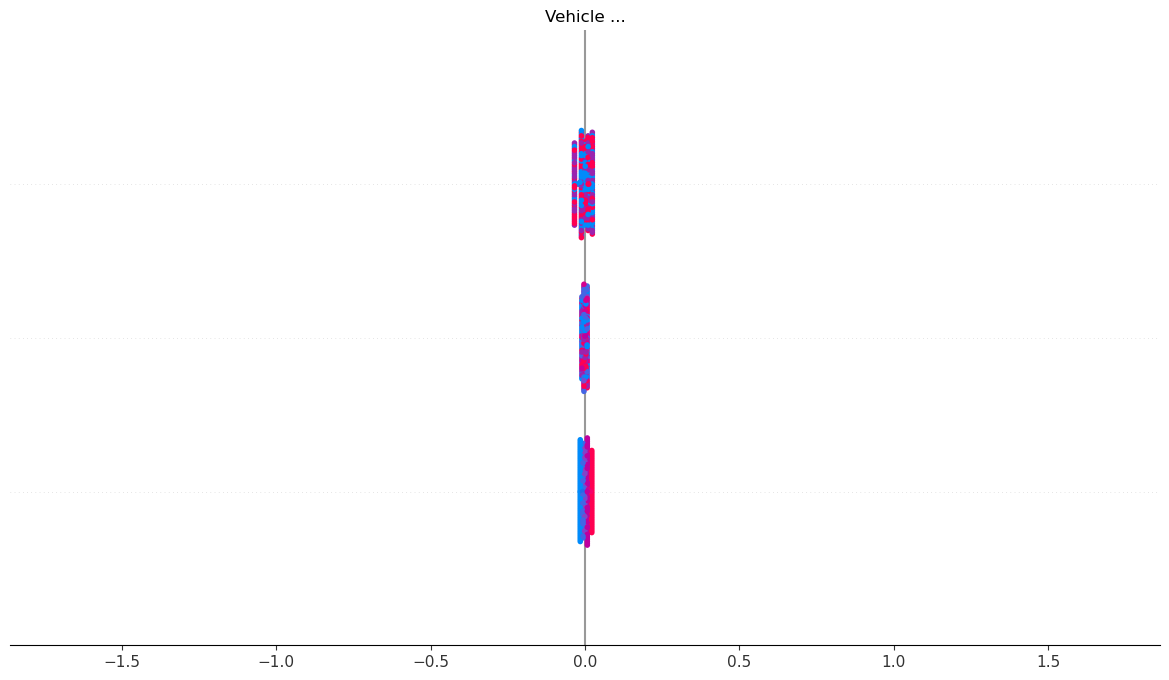

In [29]:
# SHAP analysis for Logistic Regression
explainer_lr = shap.LinearExplainer(log_reg, X_train, feature_perturbation="interventional")
shap_values_lr = explainer_lr.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values_lr, X_test, feature_names=X.columns)


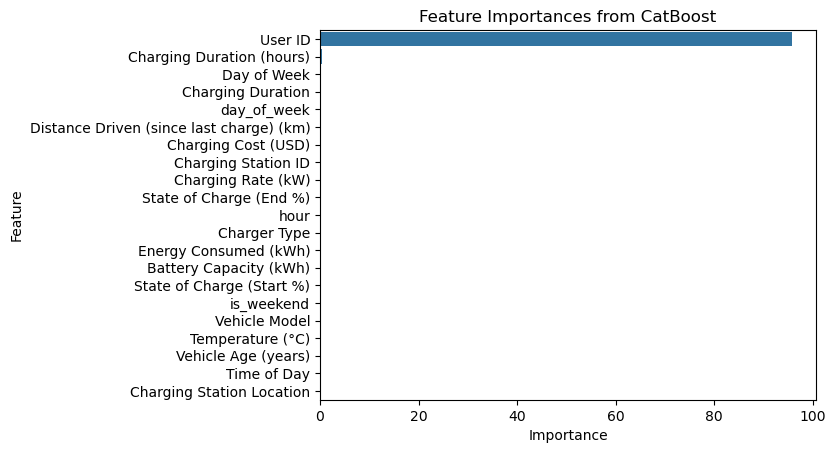

In [27]:
# Feature importance from CatBoost
importances = catboost_model.get_feature_importance()
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Plot
sns.barplot(data=feature_importances.sort_values(by='Importance', ascending=False), x='Importance', y='Feature')
plt.title('Feature Importances from CatBoost')
plt.show()


In [28]:
# Compare F1-scores
f1_lr = f1_score(y_test, y_pred_lr, average='macro')
f1_cb = f1_score(y_test, y_pred_cb, average='macro')

print(f"Logistic Regression F1-score: {f1_lr:.4f}")
print(f"CatBoost F1-score: {f1_cb:.4f}")

# Select the best model
best_model = log_reg if f1_lr >= f1_cb else catboost_model

# Save the best model
import joblib
joblib.dump(best_model, 'best_ev_charging_model.pkl')


Logistic Regression F1-score: 0.9930
CatBoost F1-score: 1.0000


['best_ev_charging_model.pkl']